<a href="https://colab.research.google.com/github/hadinursalim/Bioinformatics/blob/main/diabetes_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Diabetes**


---


Program ini membuat pengklasifikasi untuk dataset Pima Indians Diabetes - https://www.kaggle.com/uciml/pima-indians-diabetes-database. Ini adalah masalah klasifikasi biner (2-kelas). Terdapat 768 observasi dengan 8 variabel input dan 1 variabel output/target. Nama-nama variabelnya adalah sebagai berikut:
* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0


# **Step 1: import relevant libraries**

In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
SEED = 42

# **Step 2: Read in data , Exploratory Data Analysis**

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  768
Columns  :  9

Features : 
 ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Missing values :   0

Unique values :  
 Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

0    500
1    268
Name: Outcome, dtype: int64


Text(0.5, 1.0, 'Diabetes Outcome')

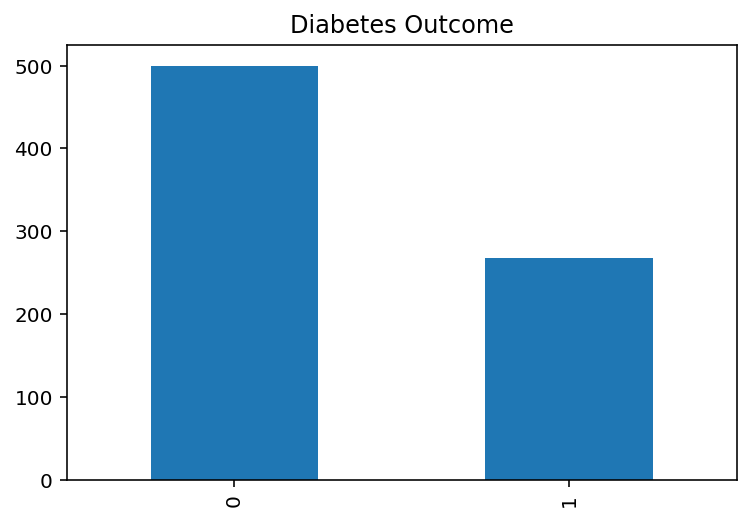

In [12]:
# Target class distribution is slightly imbalanced (see Appendix at the end of this notebook)
# '0'= no diabetes; '1'= diabetes
print(df.Outcome.value_counts())
df['Outcome'].value_counts().plot(kind='bar').set_title('Diabetes Outcome')

In [13]:
# proportion of diabetes patients (about 35% having diabetes)
df.Outcome.value_counts()[1] / df.Outcome.count()

0.3489583333333333

In [14]:
# see all numerical columns
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


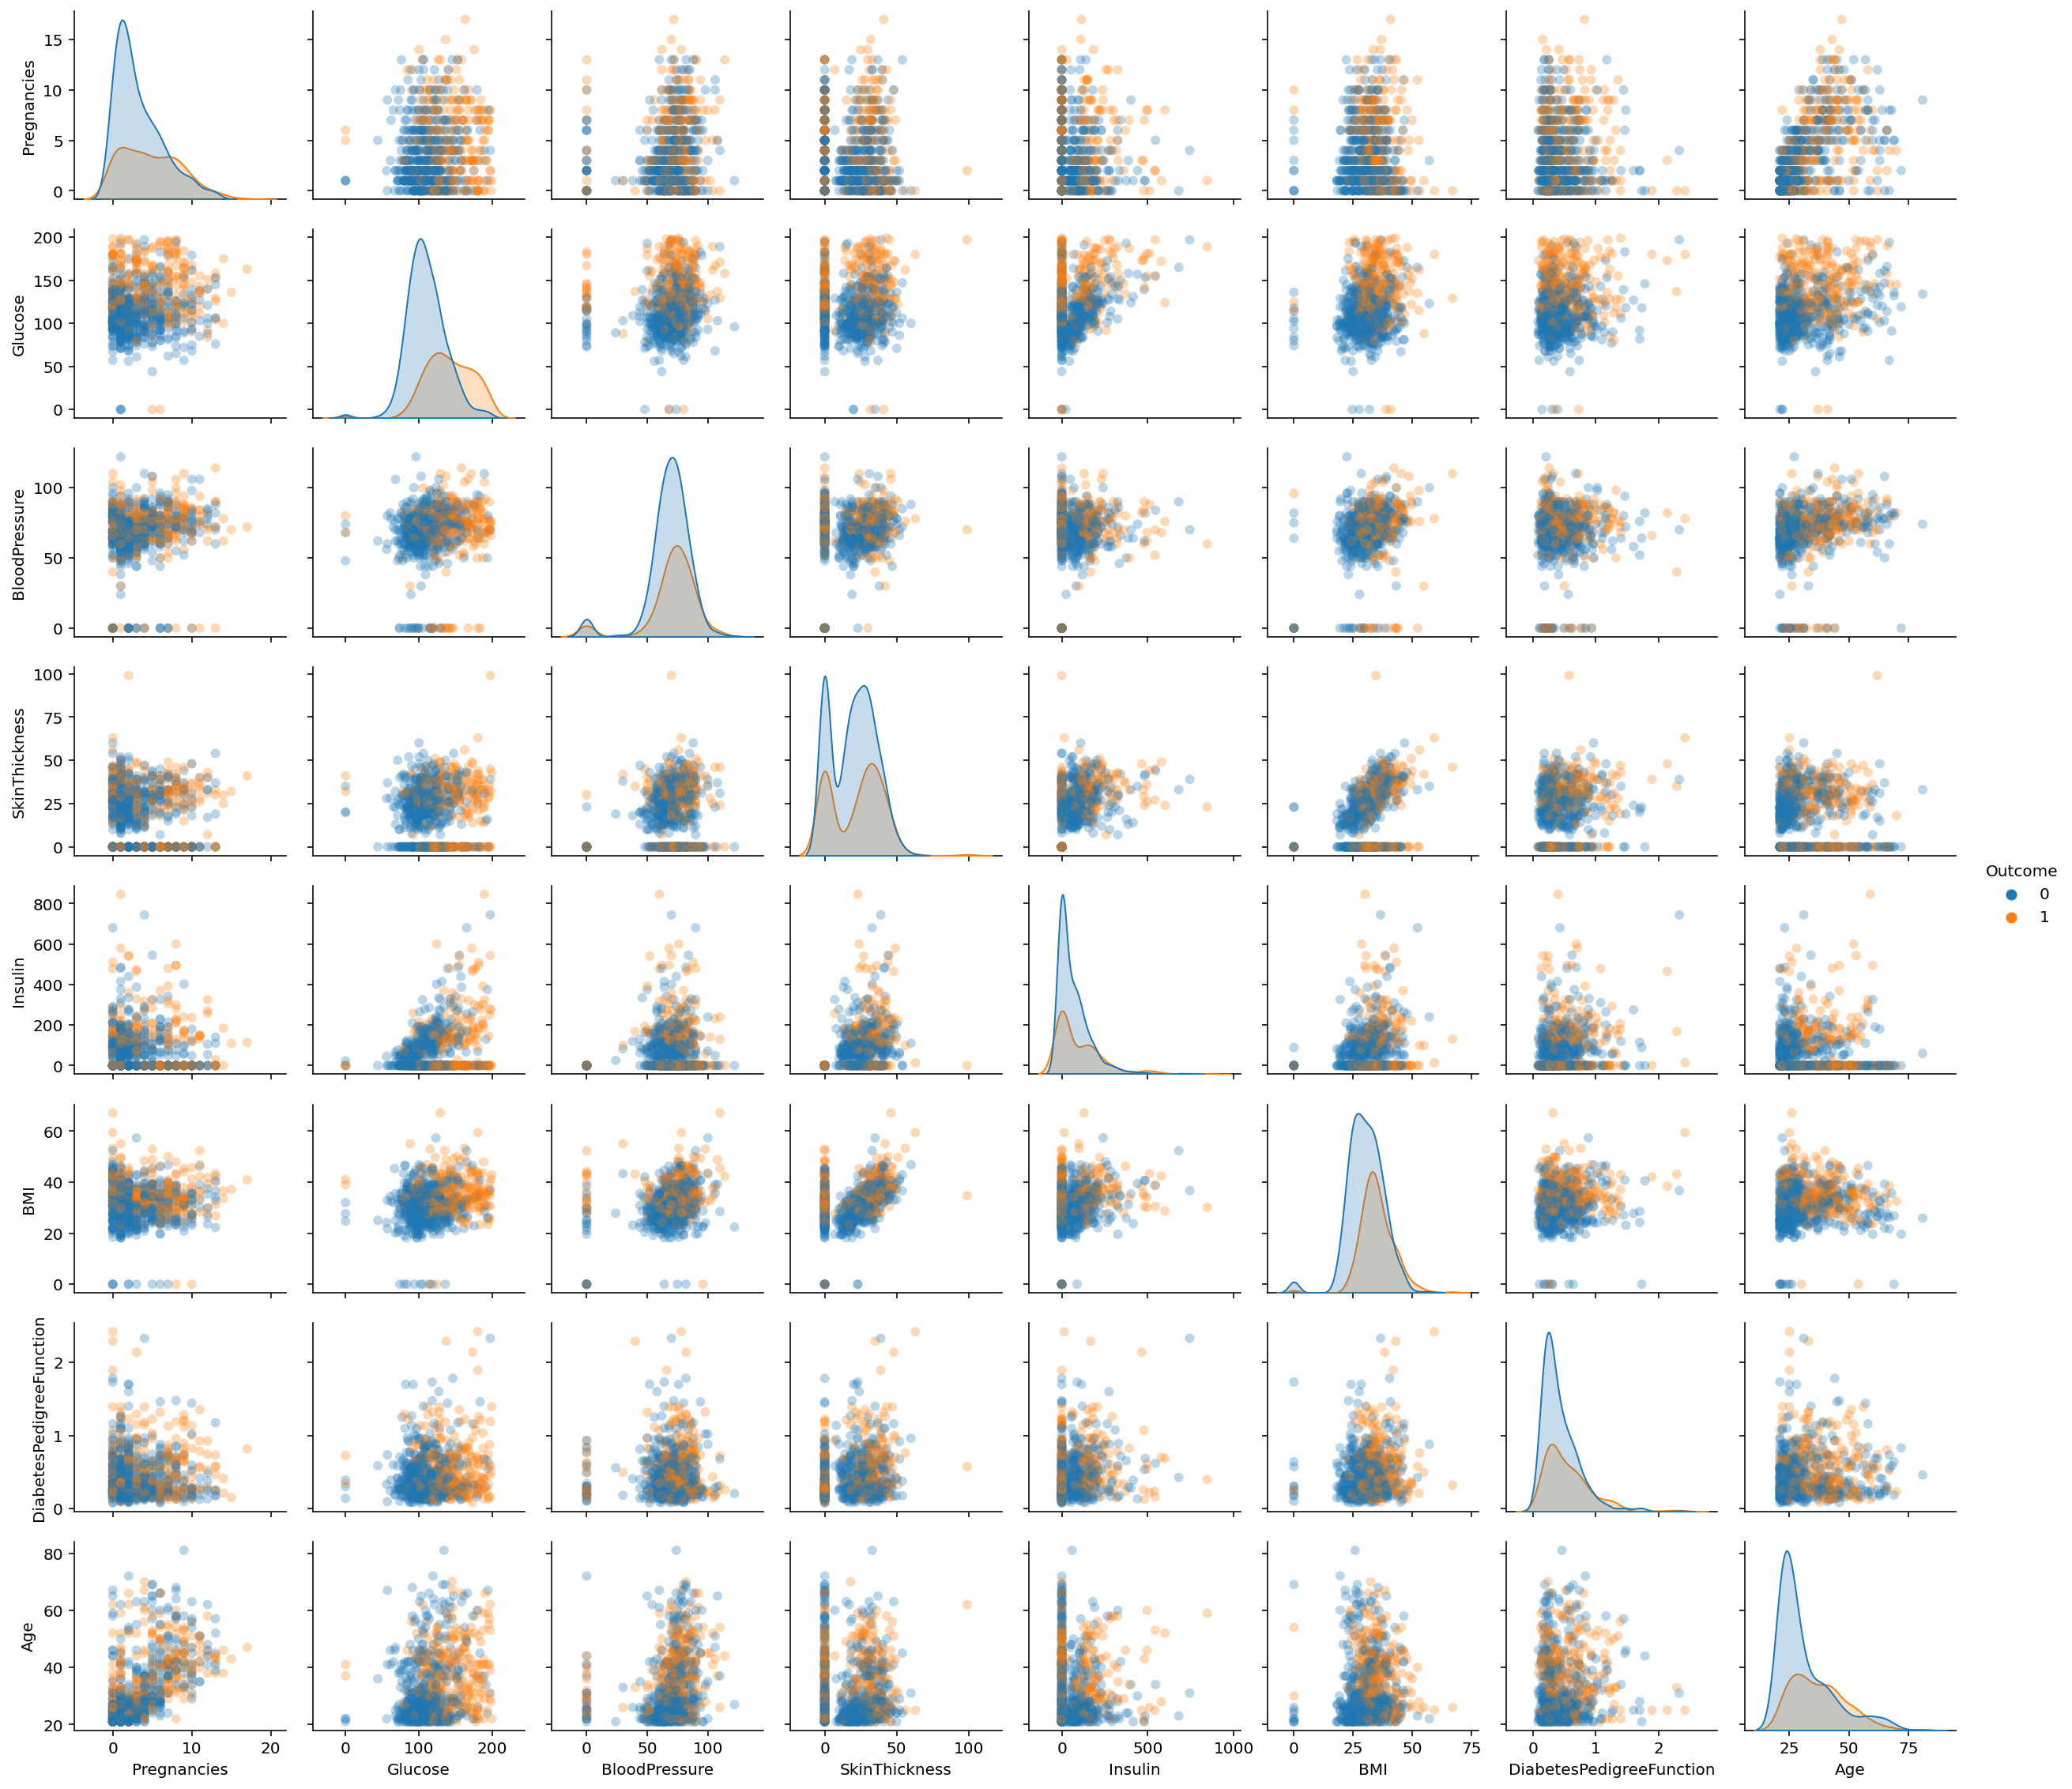

In [15]:
# to visualise pair plot
sns.pairplot(df, hue='Outcome', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

(9.5, -0.5)

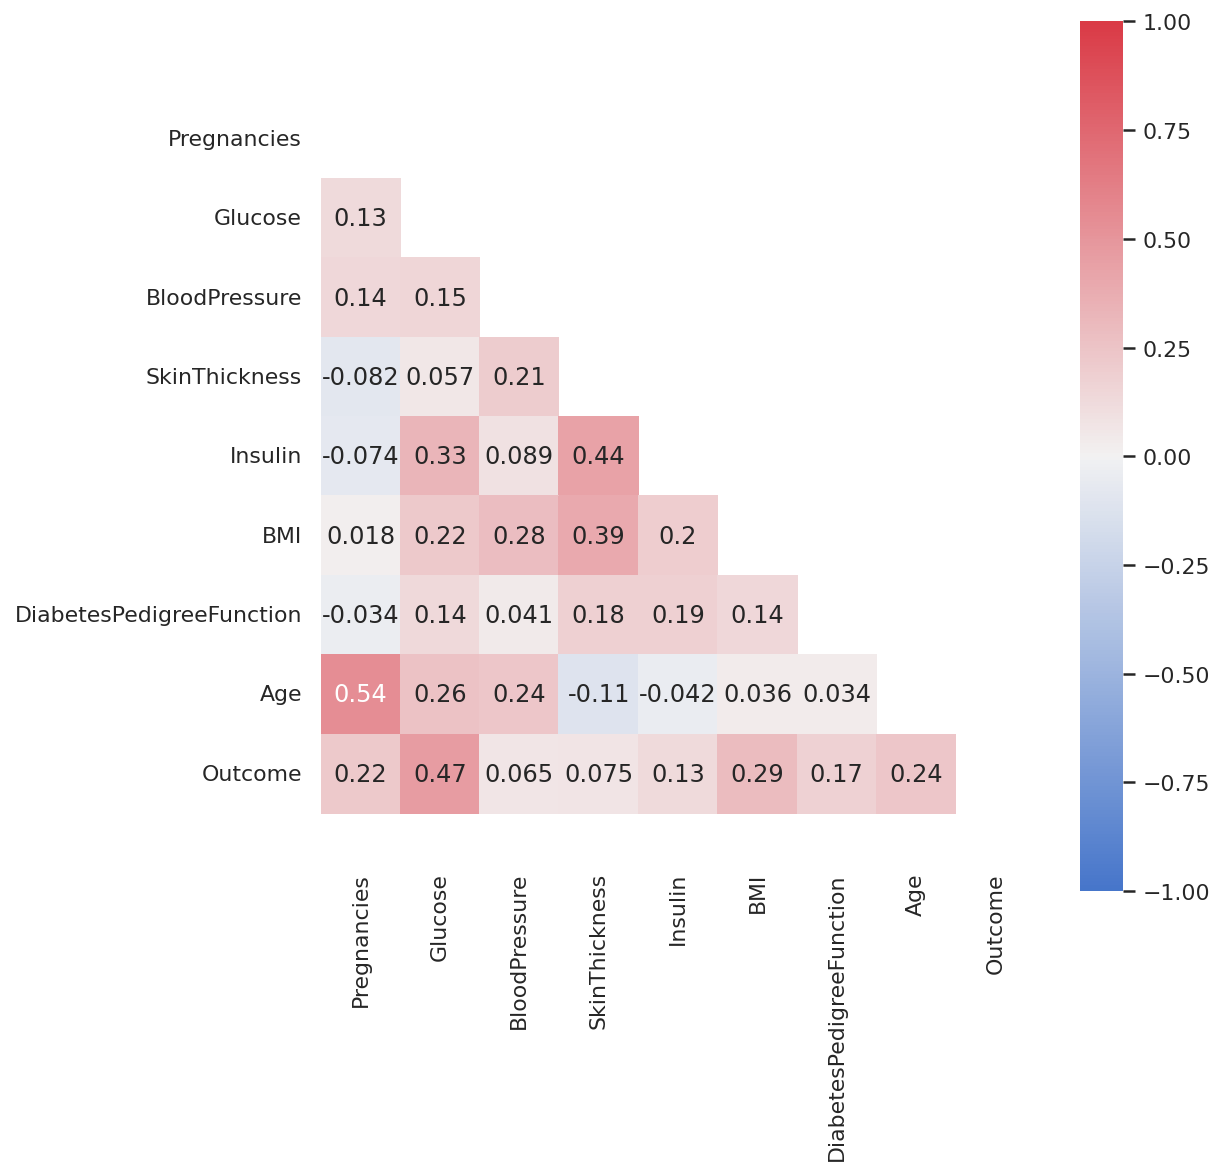

In [16]:
# Correlation Matrix Heatmap Visualization (should run this code again after removing outliers/zero values)
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(8,8))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

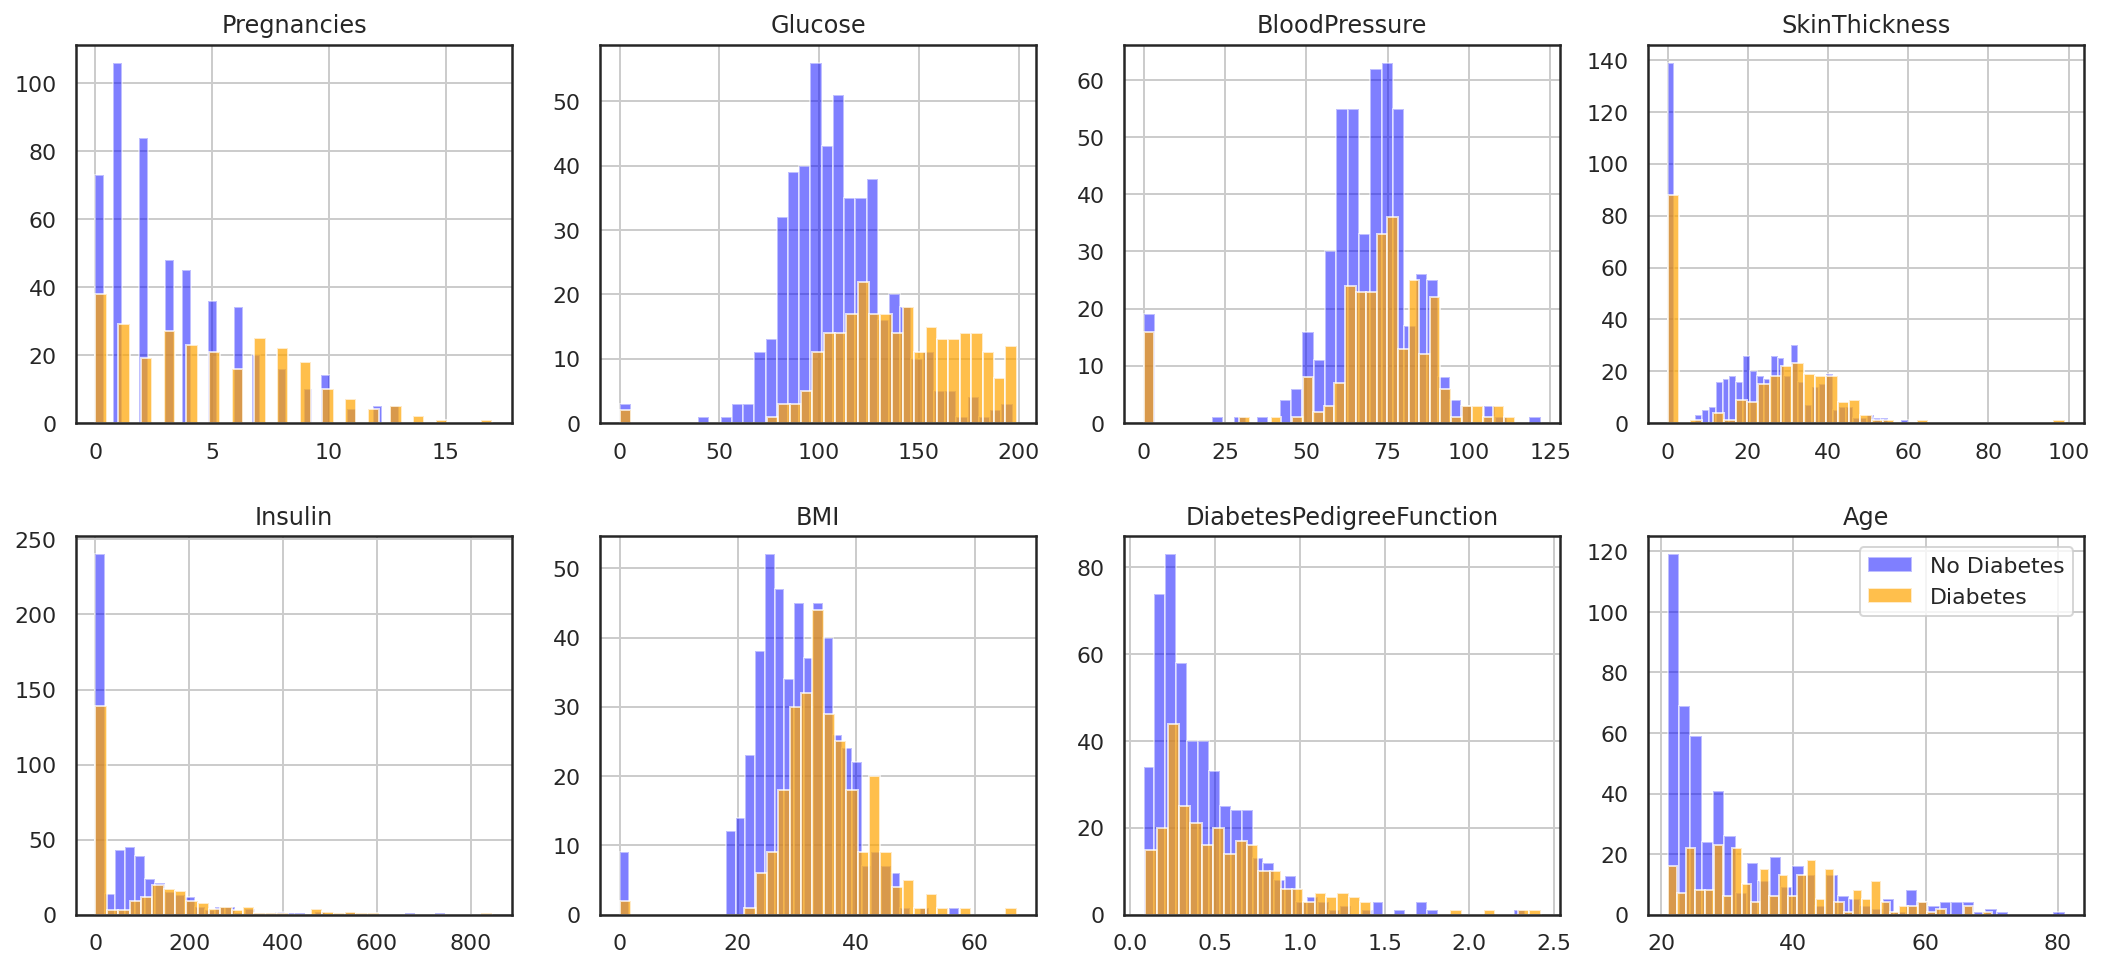

In [17]:
# To analyse feature-outcome distribution in visualisation
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

ROWS, COLS = 2, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
row, col = 0, 0
for i, feature in enumerate(features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
#     df[feature].hist(bins=35, color='green', alpha=0.5, ax=ax[row, col]).set_title(feature)  #show all, comment off below 2 lines
    df[df.Outcome==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)
    df[df.Outcome==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])
    
plt.legend(['No Diabetes', 'Diabetes'])
fig.subplots_adjust(hspace=0.3)

In [18]:
# there are zero values in Glucose, BloodPressure, SkinThickness, Insulin, BMI
# need to replace zero by median, 2 steps: replace 0 by NaN, then replace NaN by median (so that 0 will not affect median)
# after this step, run previous visualisation again

df.Glucose.replace(0, np.nan, inplace=True)
df.Glucose.replace(np.nan, df['Glucose'].median(), inplace=True)
df.BloodPressure.replace(0, np.nan, inplace=True)
df.BloodPressure.replace(np.nan, df['BloodPressure'].median(), inplace=True)
df.SkinThickness.replace(0, np.nan, inplace=True)
df.SkinThickness.replace(np.nan, df['SkinThickness'].median(), inplace=True)
df.Insulin.replace(0, np.nan, inplace=True)
df.Insulin.replace(np.nan, df['Insulin'].median(), inplace=True)
df.BMI.replace(0, np.nan, inplace=True)
df.BMI.replace(np.nan, df['BMI'].median(), inplace=True)

In [19]:
# to explore: there is 1 outlier in SkinThickness (value: 99.0)
df['SkinThickness'].max()
sorted(df['SkinThickness'])[::-1]  # descending

[99.0,
 63.0,
 60.0,
 56.0,
 54.0,
 54.0,
 52.0,
 52.0,
 51.0,
 50.0,
 50.0,
 50.0,
 49.0,
 49.0,
 49.0,
 48.0,
 48.0,
 48.0,
 48.0,
 47.0,
 47.0,
 47.0,
 47.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 46.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 45.0,
 44.0,
 44.0,
 44.0,
 44.0,
 44.0,
 43.0,
 43.0,
 43.0,
 43.0,
 43.0,
 43.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 42.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 41.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 39.0,
 38.0,
 38.0,
 38.0,
 38.0,
 38.0,
 38.0,
 38.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 37.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,

# **Step 3: Create feature X and target y dataset (X and y are commonly used in sklearn)**

In [20]:
X, y = df.drop('Outcome', axis=1), df['Outcome']
print(X.shape, y.shape)

# type(X)   # pandas.core.frame.DataFrame
# type(y)   # pandas.core.series.Series

(768, 8) (768,)


Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (768, 8)
LASSO best alpha:  0.008603464416684501
[('Glucose', 0.1880413802244648), ('BMI', 0.08931918266428746), ('Pregnancies', 0.06311584122142201), ('DiabetesPedigreeFunction', 0.036276542515315036), ('Age', 0.016956407714825764), ('BloodPressure', -0.0), ('SkinThickness', 0.0), ('Insulin', -0.0)]


Text(0.5, 1.0, 'Top Features derived by LassoCV')

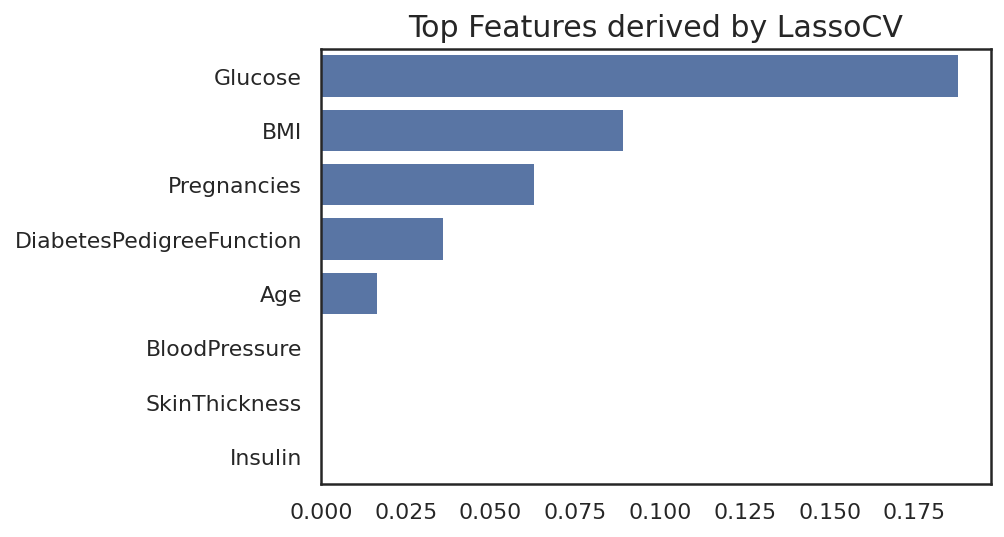

In [21]:
## to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )

# display all coefficients in the model with optimal alpha
zipped = list(zip(X.columns, lasso_model.coef_)) 
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
print(zipped)
a,b = zip(*zipped)
sns.barplot(y=list(a), x=list(b), color='b')
plt.title('Top Features derived by LassoCV', size=15)

Text(0.5, 1.0, 'Top Features derived by Random Forest')

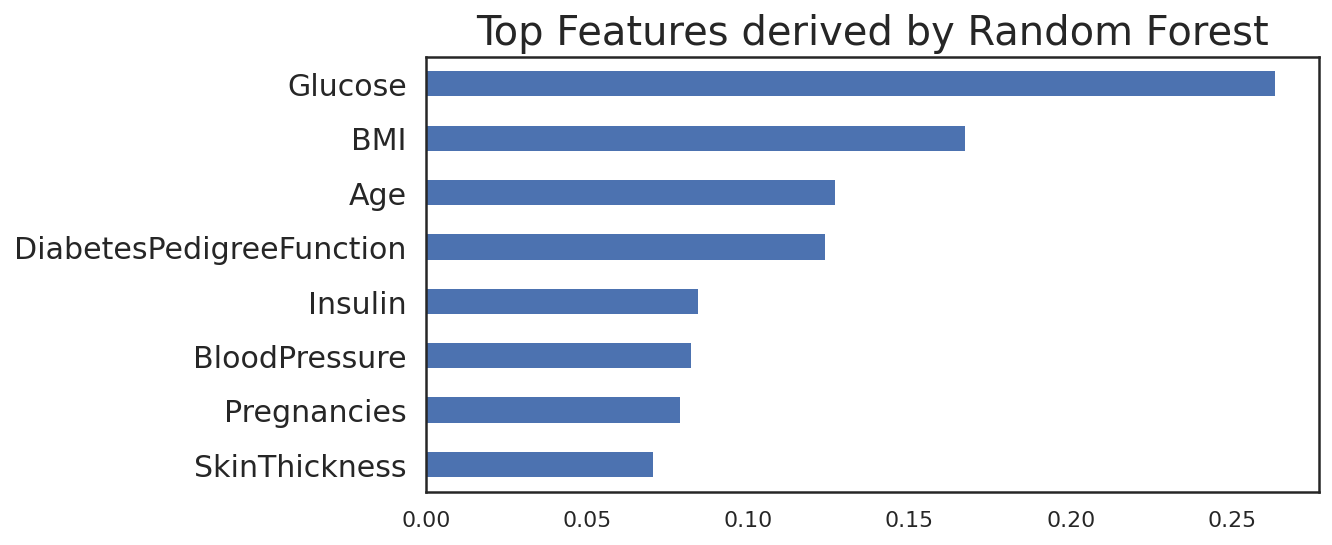

In [22]:
## To look for top features using Random Forest
# Create decision tree classifer object
rfc = RandomForestClassifier(random_state=SEED, n_estimators=100)

# Train model, note that NO scaling is required
rfc_model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(rfc_model.feature_importances_, index=X.columns)
    .nlargest(10)   # can adjust based on how many top features you want
    .plot(kind='barh', figsize=[8,4])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

In [23]:
# for linear data and model, p-value < 0.05 indicates a significant feature
import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     44.90
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           4.25e-59
Time:                        05:04:08   Log-Likelihood:                -371.86
No. Observations:                 768   AIC:                             761.7
Df Residuals:                     759   BIC:                             803.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.0237      0.104     -9.841      0.000      -1.228      -0.819
Pregnancies                  0.0206      0.005      4.074      0.000       0.011       0.031
Glucose                      0.0065      0.001     11.967      0.000       0.005       0.008
BloodPressure               -0.0012      0.001     -0.924      0.356      -0.004       0.001
SkinThickness                0.0002      0.002      0.098      0.922      -0.004       0.004
Insulin                     -0.0002      0.000     -0.850      0.396      -0.001       0.000
BMI                          0.0145      0.003      5.574      0.000       0.009       0.020
DiabetesPedigreeFunction     0.1306      0.044      2.963      0.003       0.044       0.217
Age                          0.0021      0.002      1.355      0.176      -0.001       0.005
==============================================================================
Omnibus:                       33.680   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.901
Skew:                           0.322   Prob(JB):                     6.46e-06
Kurtosis:                       2.424   Cond. No.                     1.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# **Step 4: Split data to 80:20 ratio, and perform Model Selection**



---
Tentukan parameter stratifikasi untuk membuat pemisahan sehingga proporsi nilai dalam kumpulan data terbelah yang dihasilkan akan memiliki proporsi yang sama dengan kolom stratifikasi yang disediakan.

Misalnya, jika variabel y adalah kelas kategorikal biner dengan nilai 0 dan 1 dan ada 25% dari '0 dan 75% dari '1, stratify=y akan memastikan bahwa pembagian acak Anda memiliki 25% dari '0 dan 75% dari '1 di kedua kumpulan data yang dipisah.

Reference : http://www.kmdatascience.com/2017/07/k-folds-cross-validation-in-python.html


In [26]:
X = df.drop('Outcome', axis=1)   # axis=0 for row, axis=1 for column
y = df['Outcome']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# # Data preprocessing, Scaling Numerical columns
from sklearn.preprocessing import MinMaxScaler, StandardScaler   # not much difference in results
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train (614, 8)
y_train (614,)
X_test (154, 8)
y_test (154,)


# **Cross Validation**

Use StratifiedKFold, especially if target class is imbalance

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

In [27]:
## Baseline model performance evaluation
# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)   # this may result in imbalance classes in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# to give model baseline report in dataframe 
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })   # timetaken: to be used for comparison later
    return df_model

# to evaluate baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
svc = SVC()
linearsvc = LinearSVC()

# to concat all models
df_models = pd.concat([baseline_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB'),
                       baseline_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB'),
                       baseline_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB'),
                       baseline_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression'),
                       baseline_report(knn, X_train, X_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest'),
                       baseline_report(svc, X_train, X_test, y_train, y_test, 'SVC'),
                       baseline_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.762268,0.685894,0.598450,0.636877,0.827955,10.316912,0
1,BernoulliNB,0.644942,0.000000,0.000000,0.000000,0.522461,12.111000,0
2,MultinomialNB,0.651473,0.000000,0.000000,0.000000,0.727699,12.111000,0
3,LogisticRegression,0.778489,0.758011,0.542193,0.630376,0.844743,10.092588,0
4,KNN,0.755618,0.675930,0.593023,0.629320,0.804142,9.195477,0
5,DecisionTree,0.658017,0.514977,0.528018,0.527051,0.655042,12.111124,0
6,RandomForest,0.770319,0.714411,0.574529,0.632275,0.817069,9.868326,0
7,SVC,0.775223,0.751073,0.546844,0.628770,0.839323,9.195472,0
8,LinearSVC,0.784979,0.757008,0.570100,0.649332,0.843951,10.092588,0


# **Step 5: Optimise model: hyperparameter tuning**

In [28]:
def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return df_model

In [29]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1


print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model2 = model_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')
model2.timetaken[0] = time.time() - time1


print('\n"""""" MultinomialNB """"""')
time1 = time.time()
mnb = MultinomialNB()
model3 = model_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
model3.timetaken[0] = time.time() - time1


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.6259,  0.200->0.6260,  0.300->0.5882,  0.400->0.5812,  0.500->0.5965,  0.600->0.5926,  0.700->0.5686,  0.800->0.5000,  0.900->0.4524,  1.000->0.1333,  
Looping decimal place 2
0.100->0.6259,  0.110->0.5972,  0.120->0.6014,  0.130->0.6056,  0.140->0.6143,  0.150->0.6143,  0.160->0.6087,  0.170->0.6269,  0.180->0.6316,  0.190->0.6260,  0.200->0.6260,  0.210->0.6308,  0.220->0.6357,  0.230->0.6349,  0.240->0.6240,  0.250->0.6240,  0.260->0.6129,  0.270->0.6066,  0.280->0.5833,  0.290->0.5833,  0.300->0.5882,  
Looping decimal place 3
0.210->0.6308,  0.211->0.6308,  0.212->0.6308,  0.213->0.6308,  0.214->0.6308,  0.215->0.6308,  0.216->0.6308,  0.217->0.6308,  0.218->0.6308,  0.219->0.6308,  0.220->0.6357,  0.221->0.6357,  0.222->0.6357,  0.223->0.6299,  0.224->0.6299,  0.225->0.6349,  0.226->0.6349,  0.227->0.6349,  0.228->0.

In [30]:
print('\n"""""" LogisticRegression """"""')
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model4 = model_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression')
model4.timetaken[0] = time.time() - time1


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0095, 0.0286, 0.0369, 0.0551, 0.0720, 0.0875, 0.1030, 0.1290, 0.1826, 0.2268, 0.2617, 0.2724, 0.2981, 0.3412, 0.3521, 0.3815, 0.4011, 0.4287, 0.4551, 0.4699, 0.5090, 0.5250, 0.5312, 0.5377, 0.5551, 0.5595, 0.5650, 0.5699, 0.5713, 0.5698, 0.5702, 0.5736, 0.5891, 0.5859, 0.5880, 0.5914, 0.5948, 0.6040, 0.6165, 0.6148, 0.6177, 0.6177, 0.6154, 0.6196, 0.6220, 0.6292, 0.6292, 0.6292, 0.6292, 0.6291, 0.6331, 0.6377, 0.6356, 

In [31]:
print('\n"""""" KNN """""" ')
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model5 = model_report(knn, X_train, X_test, y_train, y_test, 'KNN')
model5.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


"""""" KNN """""" 

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.5830, 0.4335, 0.6041, 0.5297, 0.6147, 0.5604, 0.5996, 0.5436, 0.6042, 0.5905, 0.6306, 0.5881, 0.6219, 0.5974, 0.6283, 0.5956, 0.6269, 0.5912, 0.6254, 0.5951, optimal cv F1 score = 0.6306
optimal value of K = 11

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.6082,  0.100->0.6225,  0.200->0.6331,  0.300->0.6142,  0.400->0.6549,  0.500->0.6139,  0.600->0.5116,  0.700->0.4359,  0.800->0.2727,  0.900->0.1639,  1.000->0.0364,  
Looping decimal place 2
0.300->0.6142,  0.310->0.6142,  0.320->0.6142,  0.330->0.6142,  0.340->0.6142,  0.350->0.6142,  0.360->0.6142,  0.370->0.6549,  0.380->0.6549,  0.390->0.6549,  0.400->0.6549,  0.410->0.6549,  0.420->0.6549,  0.430->0.6549,  0.440->0.6549,  0.450->0.6549,  0.460->0.6139,  0.470->0.6139,  0.480->0.6139,  0.490->0.6139,  0.500->0.6139,  
Lo

In [32]:
print('\n"""""" DecisionTreeClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model6 = model_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree')
model6.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.5065, 0.5032, 0.6366, 0.6055, 0.6225, 0.6341, 0.6047, 0.5853, 0.5868, optimal F1 score = 0.6366
optimal max_depth = 4

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5121,  0.100->0.5814,  0.200->0.6716,  0.300->0.6891,  0.400->0.6838,  0.500->0.6916,  0.600->0.3514,  0.700->0.3514,  0.800->0.3514,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.400->0.6838,  0.410->0.6838,  0.420->0.6838,  0.430->0.6838,  0.440->0.6838,  0.450->0.6838,  0.460->0.6916,  0.470->0.6916,  0.480->0.6916,  0.490->0.6916,  0.500->0.6916,  0.510->0.6916,  0.520->0.6916,  0.530->0.6916,  0.540->0.6916,  0.550->0.6916,  0.560->0.3514,  0.570->0.3514,  0.580->0.3514,  0.590->0.3514,  0.600->0.3514,  
Looping decimal place 3
0.450->0.6838,  0.451->0.6916,  0.452->0.6916,  0.453->0.6

In [33]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')
time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model7 = model_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest')
model7.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.6208, 150->0.6105, 200->0.6118, 250->0.6055, 300->0.6114, 350->0.6228, 400->0.6232, 450->0.6140, 500->0.6227, optimal F1 score = 0.6232
optimal n_estimators = 400

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.6341,  0.200->0.6667,  0.300->0.6567,  0.400->0.6496,  0.500->0.6078,  0.600->0.5843,  0.700->0.4872,  0.800->0.2500,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.100->0.6341,  0.110->0.6335,  0.120->0.6375,  0.130->0.6456,  0.140->0.6497,  0.150->0.6447,  0.160->0.6443,  0.170->0.6443,  0.180->0.6531,  0.190->0.6575,  0.200->0.6667,  0.210->0.6667,  0.220->0.6713,  0.230->0.6761,  0.240->0.6761,  0.250->0.6667,  0.260->0.6714,  0.270->0.6667,  0.280->0.6471,  0.290->0.6519,  0.300->0.6567,  
Looping decim

In [34]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model8 = model_report(svc, X_train, X_test, y_train, y_test, 'SVC')
model8.timetaken[0] = time.time() - time1


"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.5482,  0.200->0.6667,  0.300->0.6613,  0.400->0.6296,  0.500->0.5859,  0.600->0.5393,  0.700->0.5000,  0.800->0.3889,  0.900->0.1356,  1.000->0.0000,  
Looping decimal place 2
0.100->0.5482,  0.110->0.5714,  0.120->0.5922,  0.130->0.6092,  0.140->0.6173,  0.150->0.6154,  0.160->0.6267,  0.170->0.6351,  0.180->0.6483,  0.190->0.6573,  0.200->0.6667,  0.210->0.6423,  0.220->0.6471,  0.230->0.6466,  0.240->0.6515,  0.250->0.6565,  0.260->0.6512,  0.270->0.6512,  0.280->0.6667,  0.290->0.6720,  0.300->0.6613,  
Looping decimal place 3
0.280->0.6667,  0.281->0.6667,  0.282->0.6667,  0.283->0.6720,  0.284->0.6720,  0.285->0.6720,  0.286->0.6720,  0.287->0.6720,  0.288->0.6720,  0.289->0.6720,  0.290->0.6720,  0.291->0.6720,  0.292->0.6720,  0.293->0.6720,  0.294->0.6720,  0.295->0.6720,  0.296->0.6720,  0.297->0.6720,  0.298->0.6613,  

In [35]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model9 = model_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')   # model has no attribute 'predict_proba'

linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
accuracy      = linearsvc.score(X_test, y_test)
print('Test set: {:.2f}%'.format(100*accuracy))

y_pred = linearsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1score      = f1_score(y_test, y_pred) 
rocauc       = roc_auc_score(y_test, y_pred)
logloss      = log_loss(y_test, y_pred)
print('LinearSVC AUC: {:.4f}'.format(rocauc))
print('LinearSVC Log-loss: {:.4f}'.format(logloss))

model9 = pd.DataFrame({'model'        : ['LinearSVC'],
                       'accuracy'     : [accuracy],
                       'precision'    : [precision],
                       'recall'       : [recall],
                       'f1score'      : [f1score],
                       'rocauc'       : [rocauc],
                       'logloss'      : [logloss],
                       'timetaken'    : [time.time() - time1]       })
# Note: results keep changing in each run


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 78.83%
Test set: 70.78%
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       100
           1       0.60      0.48      0.54        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.66       154
weighted avg       0.70      0.71      0.70       154

LinearSVC confusion matrix: 
 [[83 17]
 [28 26]]
LinearSVC AUC: 0.6557
LinearSVC Log-loss: 10.0926


# **Compiling the results of all tuned models**

In [36]:
# concat all models
df_models_tuned = pd.concat([model1,model2,model3,model4,model5,model6,model7,model8,model9],axis = 0).reset_index()
df_models_tuned.drop('index', axis=1, inplace=True)
df_models_tuned

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.701299,0.546667,0.759259,0.635659,0.764630,0.944043,0.000000
1,BernoulliNB,0.649351,0.388489,1.000000,0.559585,0.553704,0.620172,0.000000
2,MultinomialNB,0.649351,0.350649,1.000000,0.519231,0.767778,0.637645,0.000000
3,LogisticRegression,0.694805,0.571429,0.888889,0.695652,0.812593,0.513213,8.000000
4,KNN,0.746753,0.627119,0.685185,0.654867,0.785185,0.940695,1.000000
5,DecisionTree,0.785714,0.698113,0.685185,0.691589,0.788704,0.761588,0.000000
6,RandomForest,0.740260,0.545455,0.888889,0.676056,0.810556,0.498487,26.000000
7,SVC,0.733766,0.591549,0.777778,0.672000,0.800741,0.529372,0.000000
8,LinearSVC,0.707792,0.604651,0.481481,0.536082,0.655741,10.092588,0.039408


In [37]:
df_models   # compare with baseline results before tuning

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.762268,0.685894,0.598450,0.636877,0.827955,10.316912,0
1,BernoulliNB,0.644942,0.000000,0.000000,0.000000,0.522461,12.111000,0
2,MultinomialNB,0.651473,0.000000,0.000000,0.000000,0.727699,12.111000,0
3,LogisticRegression,0.778489,0.758011,0.542193,0.630376,0.844743,10.092588,0
4,KNN,0.755618,0.675930,0.593023,0.629320,0.804142,9.195477,0
5,DecisionTree,0.658017,0.514977,0.528018,0.527051,0.655042,12.111124,0
6,RandomForest,0.770319,0.714411,0.574529,0.632275,0.817069,9.868326,0
7,SVC,0.775223,0.751073,0.546844,0.628770,0.839323,9.195472,0
8,LinearSVC,0.784979,0.757008,0.570100,0.649332,0.843951,10.092588,0


In [38]:
# initialise an empty df for comparison: 1 = improved, 0 = no improvement
df1 = pd.DataFrame({'model': [0]*9,'accuracy': [0]*9,'precision': [0]*9,'recall': [0]*9,'f1score': [0]*9,'rocauc': [0]*9,'logloss': [0]*9,'timetaken': [0]*9})
df1.model = df_models.model
for i in range(1,6):
    for j in range(9):
        if df_models_tuned[df_models_tuned.columns[i]][j] > df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
for i in range(6,8):
    for j in range(9):
        if df_models_tuned[df_models_tuned.columns[i]][j] < df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
df1   # Note: F1-Score has improved for all models after tuning the threshold and other hyperparameters

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0,0,1,0,0,1,0
1,BernoulliNB,1,1,1,1,1,1,0
2,MultinomialNB,0,1,1,1,1,1,0
3,LogisticRegression,0,0,1,1,0,1,0
4,KNN,0,0,1,1,0,1,0
5,DecisionTree,1,1,1,1,1,1,0
6,RandomForest,0,0,1,1,0,1,0
7,SVC,0,0,1,1,0,1,0
8,LinearSVC,0,0,0,0,0,0,0


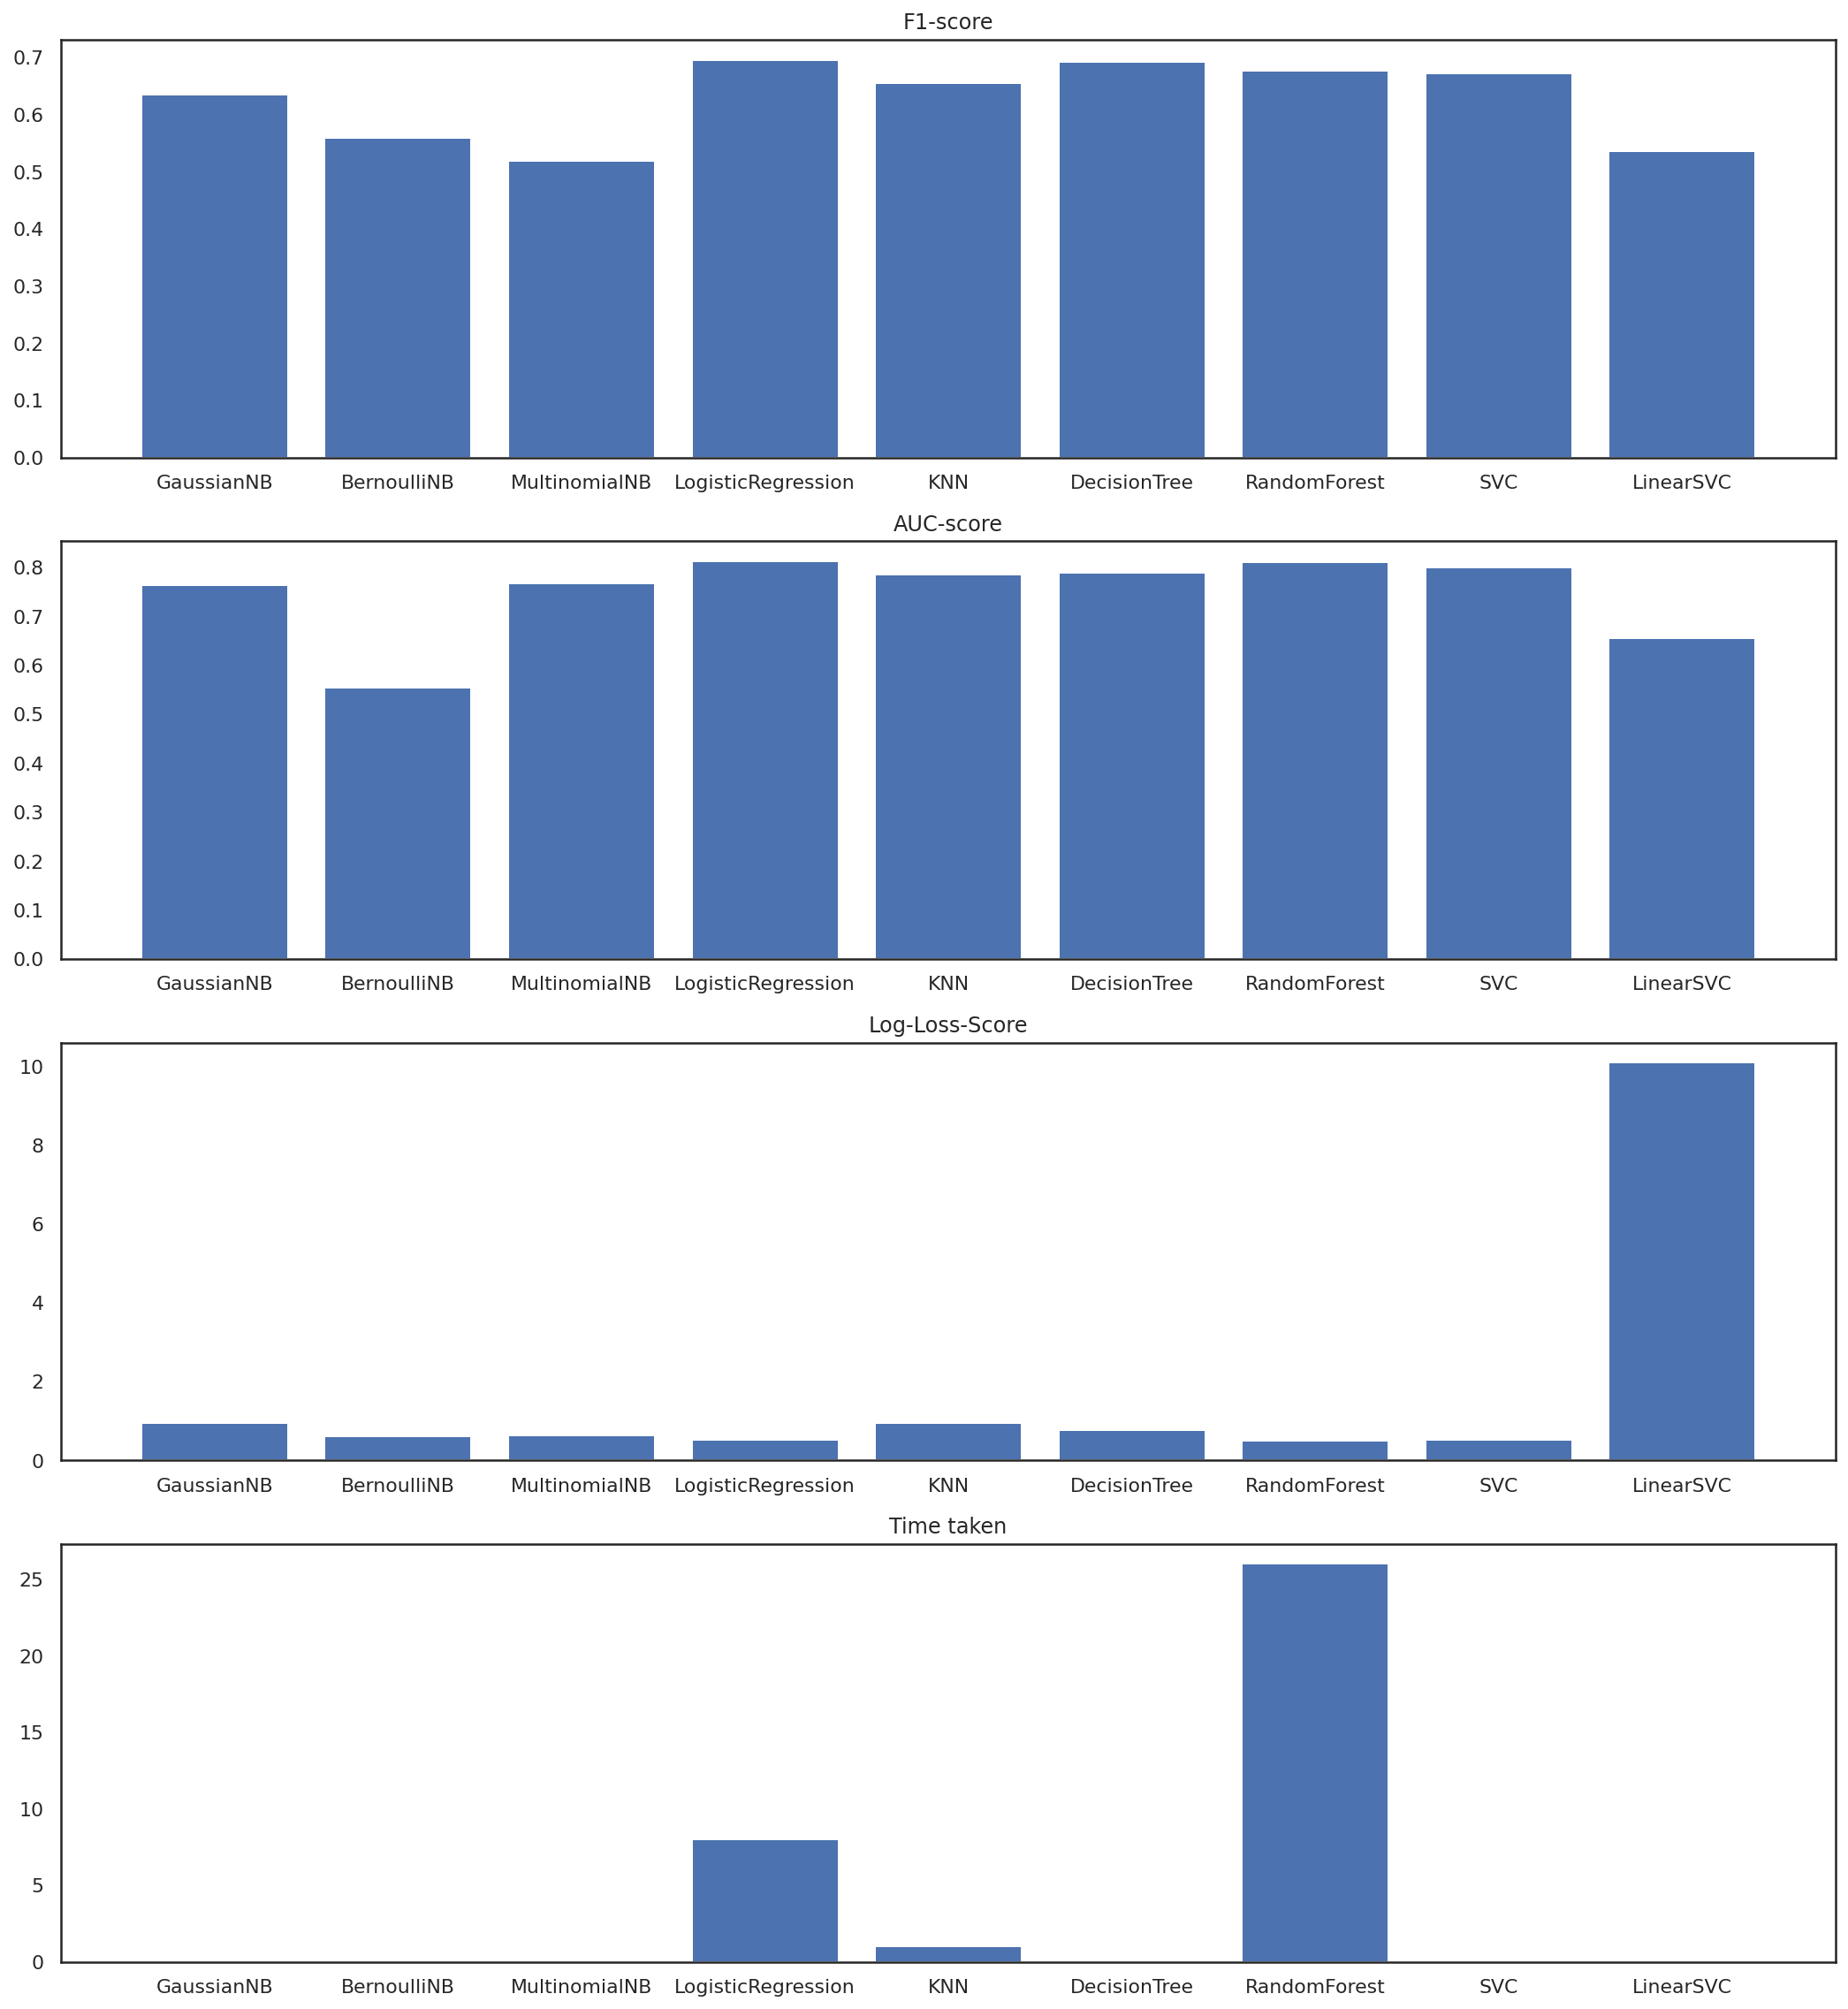

In [39]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(df_models_tuned.model, df_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(df_models_tuned.model, df_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(df_models_tuned.model, df_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(df_models_tuned.model, df_models_tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

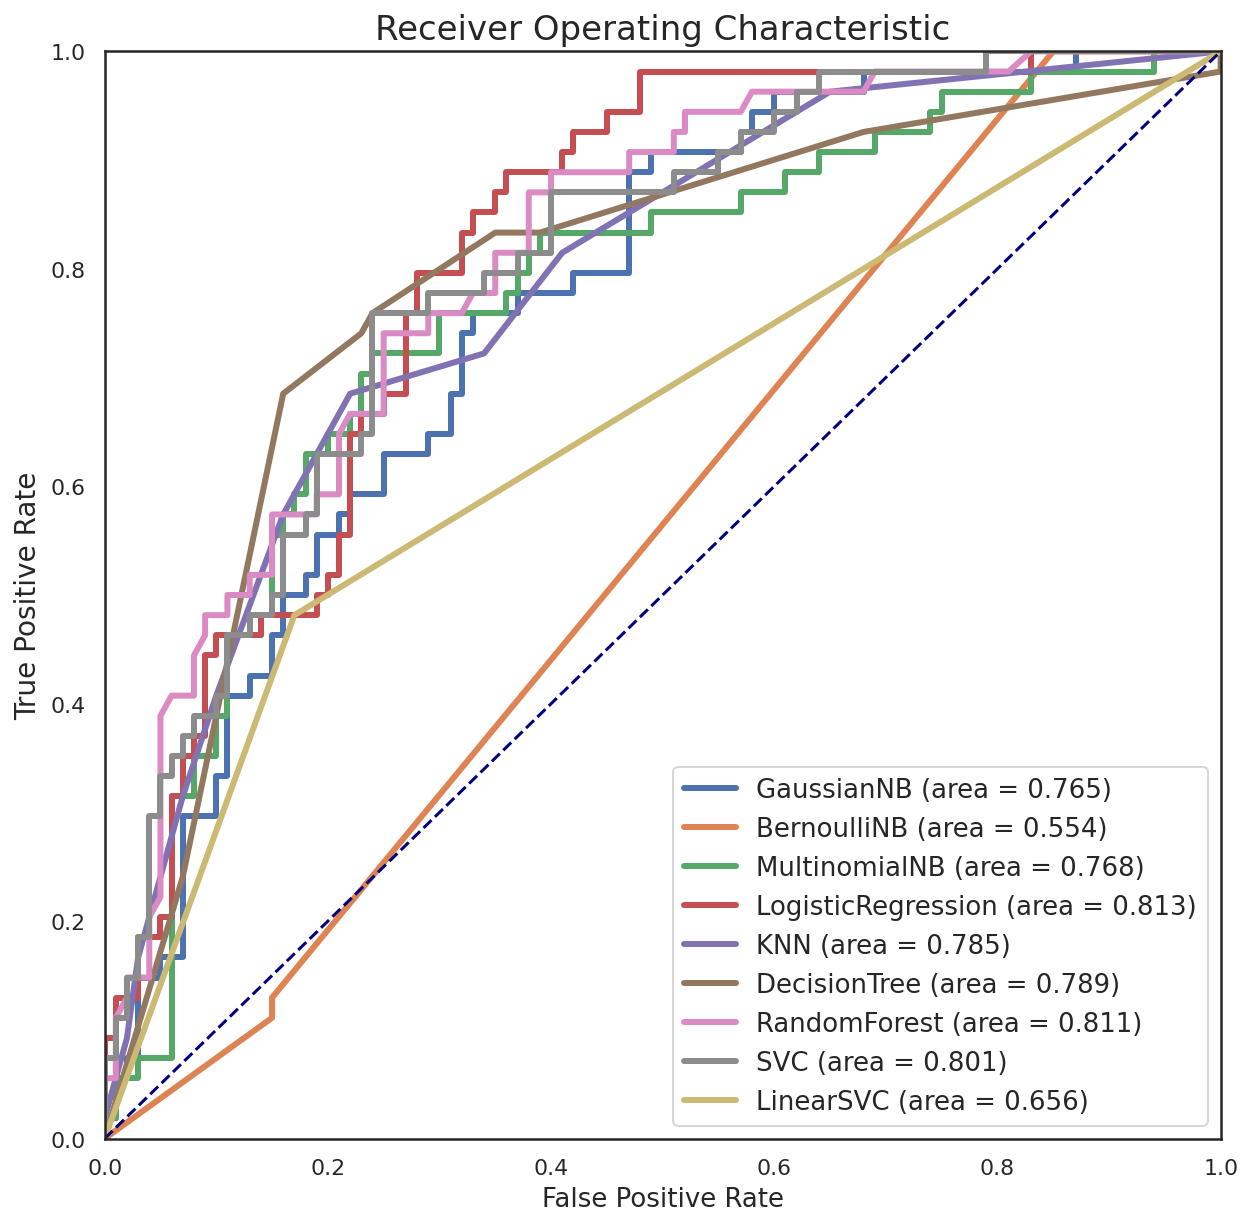

In [40]:
# plot the ROC curves
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, mnb, logit, knn, decisiontree, randomforest, svc, linearsvc]

for i in range(8):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=df_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = linearsvc.predict(X_test)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='LinearSVC (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [41]:
# see how model confusion matrix varies with threshold
bestmodel = gnb

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no diabetes', 'diabetes'],
           yticklabels=['no diabetes', 'diabetes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [42]:
# Difference between roc_auc_score(y_test, y_pred) and auc(fpr, tpr)
y_pred = gnb.predict(X_test)
model_roc_auc = roc_auc_score(y_test, y_pred)   # this is AUC score when threshold is default 0.5
print('gnb', 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 

y_pred = gnb.predict_proba(X_test)[:,1]>0.5    # predict_proba to adjust threshold to 0.5, same results
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('gnb', 'AUC: {:.4f}'.format(model_auc))

y_pred = gnb.predict_proba(X_test)[:,1]   # use this for optimal threshold after tuning
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('gnb', 'AUC: {:.4f}'.format(model_auc))

gnb roc_auc_score: 0.6848
gnb AUC: 0.6848
gnb AUC: 0.7646


**Appendix: Use GridSearchCV to tune the model, eg. Logistic Regression**

For most algorithms, there are parameters to tune to model the data better. One approach is to use grid search to find a suitable parameter that builds an optimal model.

In [43]:
# pass in parameters of all these values in the grids, see which gives the best score.
param_grid = {'C': [0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), 
                    param_grid, cv=5, scoring='f1') # cv=5 refers to cross validation in the training dataset

grid.fit(X_train, y_train)

print("Best cross-validation score: {:.3f}".format(grid.best_score_))   # scoring='f1'; or default using accuracy
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

#make prediction
lr = grid.best_estimator_
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Testing metrics after grid search')
print('Accuracy', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))

Best cross-validation score: 0.648
Best parameters:  {'C': 20}
Best estimator:  LogisticRegression(C=20, solver='liblinear')
Testing metrics after grid search
Accuracy 0.6948051948051948
Precision 0.5777777777777777
Recall 0.48148148148148145


**Appendix: To handle imbalance data**

This two-class dataset seems imbalanced (65% vs 35%). As a result, there is a possibility that one class is over-represented and the model built might be biased towards to majority. I have tried to solve this by oversampling the smaller class but there was no improvement. F1-score dropped from 0.66 to 0.63

In [46]:
# baseline model performance (before  oversampling)
print('X_train.shape:', X_train.shape)
print(pd.value_counts(pd.Series(y_train)))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print('Model accuracy is', accuracy_score(y_test, y_pred))
print('Model accuracy is', gnb.score(X_test, y_test))   # same result (.score uses accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

X_train.shape: (614, 8)
0    400
1    214
Name: Outcome, dtype: int64
Model accuracy is 0.7012987012987013
Model accuracy is 0.7012987012987013
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       100
           1       0.57      0.63      0.60        54

    accuracy                           0.70       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.70      0.70       154

[[74 26]
 [20 34]]
